# Predicting Bike Rentals

**What the project is about:** Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a [CSV file](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset), which I'll work with in this project. 

**Goal of the project:** My goal is to try to predict the total number of bikes people rented in a given hour.  To accomplish this, I'll create a few different machine learning models and evaluate their performance.

## Introducing the Dataset

In [6]:
import pandas

bike_rentals = pandas.read_csv("bike_rental_hour.csv")
bike_rentals.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1


Let's look at a histogram of the `cnt` column of `bike_rentals` and examine the distribution of total rentals.

(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

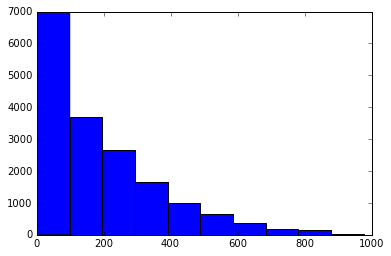

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.hist(bike_rentals["cnt"])

Next, I'll use the [corr](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) method on the `bike_rentals` dataframe to explore how each column is correlated with `cnt`.

In [8]:
bike_rentals.corr()["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

## Calculating Features


It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information or distilling existing information.

For example, the `hr` column in `bike_rentals` contains the hours during which bikes are rented, from 1 to 24. A machine treats each hour differently, without understanding that certain hours are related. I can introduce some order into the process by creating a new column with labels for `morning`, `afternoon`, `evening`, and `night`. This bundles similar times together, enabling the model to make better decisions.

In [9]:
def assign_label(hour):
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3

bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

## Error Metric

Before I can begin applying machine learning algorithms, I'll need to split the data into training and testing sets. This will enable me to train an algorithm using the training set, and evaluate its accuracy on the testing set. If I train an algorithm on the training data, then evaluate its performance on the same data, I can get an unrealistically low error value, due to overfitting.

Based on your explorations of the `cnt` column, the mean squared error metric makes the most sense to evaluate the performance of the machine learning algorithms. MSE works on continuous numeric data, which fits the data quite well.

In [10]:
train = bike_rentals.sample(frac=.8)

In [11]:
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Applying Linear Regression

Linear regression works best when predictors are linearly correlated to the target and also independent - in other words, they don't change meaning when I combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

With this in mind, I'll need to ignore the `casual` and `registered` columns because `cnt` is derived from them. If I'm trying to predict the number of people who rent bikes in a given hour (`cnt`), it doesn't make sense that I'd already know `casual` or `registered`, because those numbers are added together to get `cnt`.

Below, I've created a list of predictor columns to use in training and predictions. I then use the [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) class from sklearn to train a machine learning algorithm on `train`.

In [12]:
from sklearn.linear_model import LinearRegression

predictors = list(train.columns)
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")

reg = LinearRegression()

reg.fit(train[predictors], train["cnt"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [13]:
import numpy
predictions = reg.predict(test[predictors])

numpy.mean((predictions - test["cnt"]) ** 2)

17207.91668099656

The error between the predictions and the actual values is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

## Applying Decision Trees

Now I'm ready to apply the decision tree algorithm. I'll be able to compare the decision tree algorithm error with the error from linear regression, which will enable me to pick the right algorithm for this dataset.

Decision trees tend to predict outcomes much more reliably than linear regression models, because a decision tree is a fairly complex model. It also tends to overfit, particularly when I don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability - small changes in the input data can result in a very different output model.

Below, I've used  the [DecisionTreeRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) class to fit a decision tree algorithm to the `train` data. I then made predictions using the DecisionTreeRegressor class on `test`. To finish, I calculated the error between the predictions and the actual values.

In [14]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(min_samples_leaf=5)

reg.fit(train[predictors], train["cnt"])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [15]:
predictions = reg.predict(test[predictors])

numpy.mean((predictions - test["cnt"]) ** 2)

2755.6389217466995

In [16]:
reg = DecisionTreeRegressor(min_samples_leaf=2)

reg.fit(train[predictors], train["cnt"])

predictions = reg.predict(test[predictors])

numpy.mean((predictions - test["cnt"]) ** 2)

3436.6609209180415

By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

## Applying Random Forests

I can now apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests are prone to overfitting, so it's important to tune parameters like maximum depth and minimum samples per leaf.

Just as I did before, I will use the [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) class to fit a random forest algorithm to the `train` data, then make predictions using the RandomForestRegressor class on `test`. I will then calculate the error between the predictions and the actual values.

In [17]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(min_samples_leaf=5)
reg.fit(train[predictors], train["cnt"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [18]:
predictions = reg.predict(test[predictors])

numpy.mean((predictions - test["cnt"]) ** 2)

2024.5025182295424

By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.